⭐ Image Prep

In [1]:
import sys
import os
from pathlib import Path

current_dir = Path(os.getcwd())
module_dir = current_dir.parent / 'modules'
sys.path.insert(0, str(module_dir))

import img_preprocessing as img

In [7]:
healthy_count = 0
for file in os.listdir('../../MOCK/data/PlantVillage/Potato___Early_blight'): 
    healthy_count+=1
print(f"Number of potato imgs: {healthy_count}")

sctld_count = 0
for file in os.listdir('../../MOCK/data/PlantVillage/Potato___healthy'): 
    sctld_count+=1
print(f"Number of healthy imgs: {sctld_count}")

print(f"Total images: {sctld_count + healthy_count}")

Number of potato imgs: 1000
Number of healthy imgs: 152
Total images: 1152


0

In [9]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3 # RGB
EPOCHS = 50
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "../../MOCK/data/PlantVillage", 
    seed = 123, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names

In [13]:
for image_batch, labels_batch in dataset.take(1): 
    print(image_batch.shape)
    print(labels_batch)

(32, 224, 224, 3)
tf.Tensor([1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0], shape=(32,), dtype=int32)


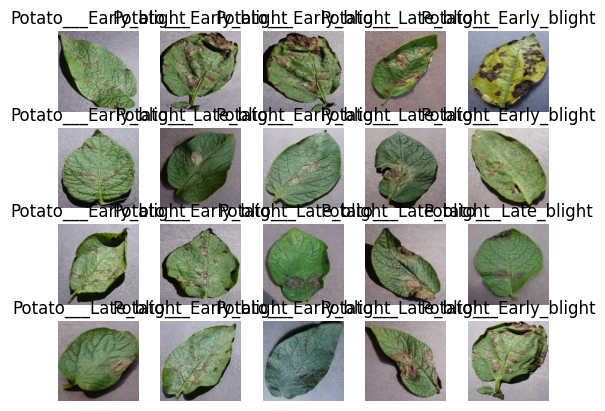

In [14]:
for image_batch, label_batch in dataset.take(1): 
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [15]:
train_size = 0.8
len(dataset) 

68

In [16]:
train_ds = dataset.take(23)
len(train_ds)
test_ds = dataset.skip(23)
val_ds = test_ds.take(int(len(test_ds)/2)) 
test_ds = test_ds.skip(int(len(test_ds)/2))

In [17]:
def split_dataset(ds, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=1000): 
    assert (train_split + test_split + val_split == 1)
    ds_size = len(ds)
    if shuffle: 
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, test_ds, val_ds = split_dataset(dataset)

⭐ DATA AUGUMENTATION

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./224), 
])

data_augumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), 
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2), 
    layers.RandomContrast(0.2)
])

In [20]:
def data_augmentation(image, label):
    image = resize_and_rescale(image)  # Apply resizing and rescaling
    image = data_augumentation(image)  # Apply data augmentation
    return image, label

train_ds = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)


In [17]:
# save time for computer to read the images. 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

⭐ BUILD MODEL

In [18]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
inputs = layers.Input(shape=input_shape)

In [27]:
# load model

In [28]:
from tensorflow.keras.applications import EfficientNetV2L

In [29]:
model = EfficientNetV2L(weights='imagenet', 
                        include_top=False, 
                        input_shape = input_shape
                       )

for layer in model.layers:
    layer.trainable = False 

model.summary()

Model: "efficientnetv2-l"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 32)      │           9,216 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 32)      │             128 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 32)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_add (Add)             │ (None, 112, 112, 32)      │               0 │ block1a_project_activatio… │
│                               │                           │                 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 112, 112, 32)      │           9,216 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 112, 112, 32)      │             128 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 112, 112, 32)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 112, 112, 32)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 112, 112, 32)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 117,746,848 (449.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 117,746,848 (449.17 MB)

In [71]:
from tensorflow.keras.layers import * 

In [72]:
cb_model = tf.keras.models.Sequential([model, 
                                       GlobalAveragePooling2D(), 
                                       Dense(512, activation='relu'), 
                                       Dropout(0.2), 
                                       Dense(512, activation='relu'), 
                                       Dropout(0.2), 
                                       Dense(1, activation='sigmoid')
                       
])
cb_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,665,889 (452.67 MB)

 Trainable params: 919,041 (3.51 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

⭐ TRAIN MODEL

In [78]:
from tensorflow.keras.metrics import *

metrics = ['accuracy', Precision(), Recall(), AUC()]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

cb_model.compile(loss=BinaryCrossentropy(), 
                 optimizer=Adam(learning_rate=0.001), 
                 metrics=metrics
                )


In [79]:
for images, labels in train_ds.take(1):
    print("Labels shape:", labels.shape)
    print("Labels example:", labels.numpy())
    print("Labels dtype:", labels.dtype)


Labels shape: (32,)
Labels example: [1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1]
Labels dtype: <dtype: 'int32'>


In [80]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, monitor='val_loss')

In [ ]:
cb_model.fit(train_ds, 
             epochs=EPOCHS, 
             validation_data=val_ds, 
             callbacks=[es]        )

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5126 - auc_5: 0.5146 - loss: 0.6975 - precision_5: 0.5191 - recall_5: 0.4907 